# CS349 Final: Coronavirus Experiments

## Initialization

In [1]:
import os
from utils import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as DT
from matplotlib.font_manager import FontProperties


# ----------- DATA PATHS --------------
BASE_PATH = './COVID-19/csse_covid_19_data/'
TIME_SERIES_PATH = 'csse_covid_19_time_series'
US_CONFIRMED_PATH = 'time_series_covid19_confirmed_US.csv'
# --------------------------------------



## US State-by-State Analysis

### Load State Time Series Data

In [2]:

us_confirmed = os.path.join(BASE_PATH, TIME_SERIES_PATH, US_CONFIRMED_PATH)
us_confirmed = data.load_csv_data(us_confirmed)


# Aggregate data for each state
states = []
dates = list(us_confirmed.columns[11:])
cases = []

for state in np.unique(us_confirmed['Province_State']):
    df = data.filter_by_attribute(
        us_confirmed, "Province_State", state)
    state_cases = np.array(df.iloc[:, 11:])
    cases.append(list(np.sum(state_cases, axis=0)))
    states.append(state)

states = np.array(states)
dates = np.array(dates)
cases = np.array(cases)

    

### Visualize Data

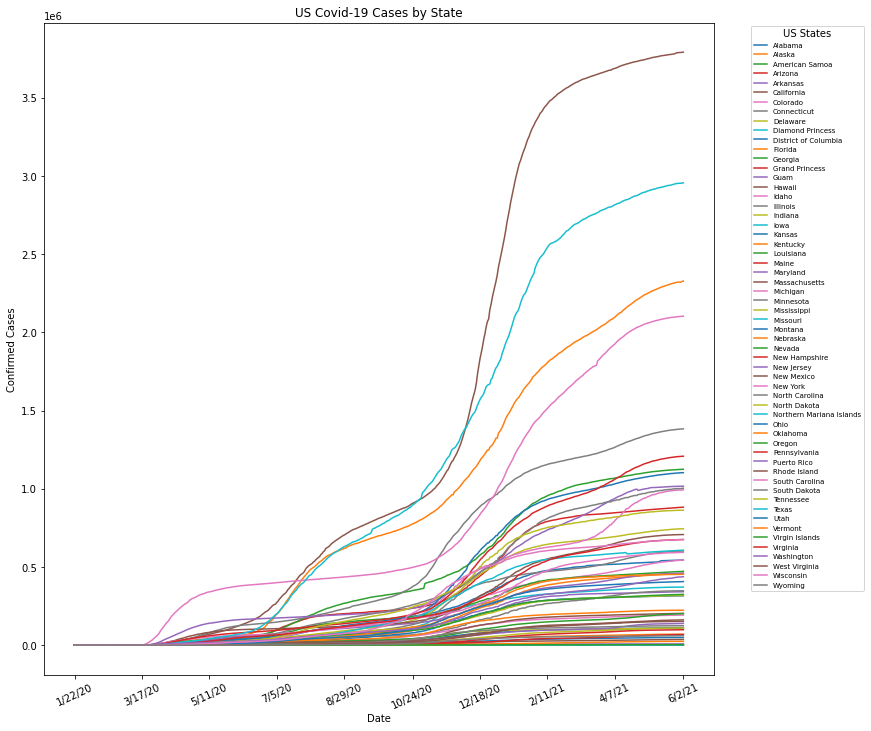

In [3]:
xtick_dates = [DT.datetime.strptime(date, '%m/%d/%y') for date in dates]

fig, axes = plt.subplots(1, 1, figsize=(12, 12))

plt.title('US Covid-19 Cases by State')
plt.ylabel('Confirmed Cases')
plt.xlabel('Date')
for i in range(states.shape[0]):
    axes.plot(dates, cases[i], label=states[i])
# Code for modifying legend obtained from:
#   https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
fontP = FontProperties()
fontP.set_size('x-small')
plt.legend(title='US States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
axes.set_xticks(dates[np.linspace(0, dates.shape[0]-1, 10, dtype=int)])
plt.xticks(rotation=25)

plt.savefig('./exp/results/US_timeseries.png')

### Fit State-by-State Models
Entries with only 0 cases will not converge in np.polyfit, so they are removed from data

**model_X**: cases on given day

**model_Y**: new cases confirmed the next day

In [4]:
# Remove entries with little data 
TOTAL_CUTOFF = 20000

model_X = []
model_Y = []
model_states = []
removed_states = []
for i in range(cases.shape[0]):
    if np.max(cases[i]) <= TOTAL_CUTOFF: 
        removed_states.append(states[i])
        continue
    model_X.append(cases[i, :-1])
    model_Y.append(np.diff(cases[i], 1))
    model_states.append(states[i])

model_X = np.array(model_X)
model_Y = np.array(model_Y)
model_states = np.array(model_states)

print('States removed for total cases <= {0}: {1}'.format(TOTAL_CUTOFF, removed_states))

States removed for total cases <= 20000: ['American Samoa', 'Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands', 'Virgin Islands']


Fit np.polyfit models with degree=DEGREE

In [5]:
DEGREE = 1

models = np.array([np.polyfit(model_X[i], model_Y[i], DEGREE) for i in range(model_X.shape[0])])

### Visualize Models

#### Model Graph over Number of Cases

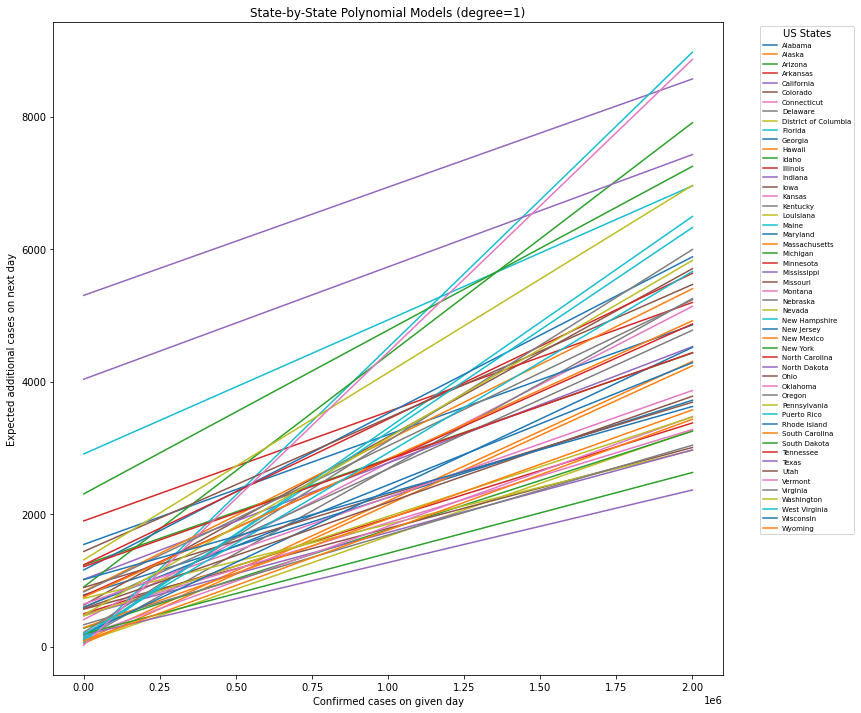

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12))

plt.title('State-by-State Polynomial Models (degree={0})'.format(DEGREE))
plt.xlabel('Confirmed cases on given day')
plt.ylabel('Expected additional cases on next day')

median = np.median(model_X)
#case_vals = np.linspace(median-1000, median+1000, num=10)
case_vals = np.linspace(0, 2000000, num=1000)

for i in range(model_states.shape[0]):
    plt.plot(case_vals, np.polyval(models[i], case_vals), label=model_states[i])
plt.legend(title='US States', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

plt.savefig('./exp/results/US_models.png')

#### Bar Graph of Model Slopes

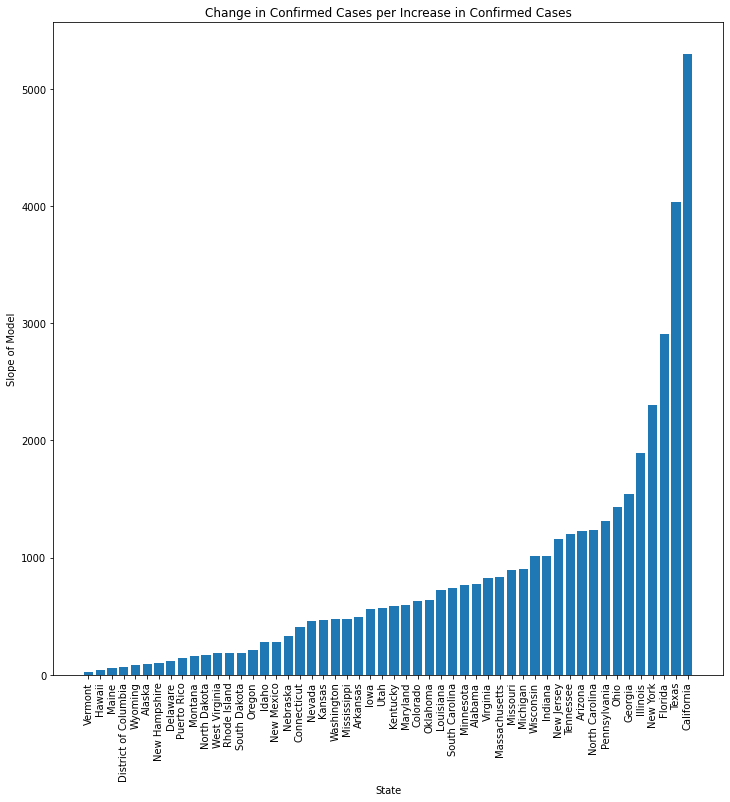

In [7]:
sorted_models = models[np.argsort(models[:, 1])]
sorted_states = model_states[np.argsort(models[:, 1])]

fig, axes = plt.subplots(1, 1, figsize=(12, 12))

plt.title('Change in Confirmed Cases per Increase in Confirmed Cases')
plt.ylabel('Slope of Model')
plt.xlabel('State')
plt.xticks(rotation=90)

plt.bar(sorted_states, sorted_models[:, 1])

plt.savefig('./exp/results/US_bargraph.png')